In [1]:
using DifferentialEquations
using Plots

In [2]:
function mass_no_friction(du, u, p, t)
    
    # Unpack parameters 
    m = p[1] # mass
    controller = p[2] # Controller
    
    du[1] = u[2]
    du[2] = controller(u[1], u[2])/m    
end

mass_no_friction (generic function with 1 method)

In [3]:
f(x,y) = 2.0;
mass_no_friction([0,0], [1.0, 0.0], [1.0, f], 5.0)

2.0

In [4]:
# Parameters
m = 1.0;

# No control
τ(u1,u2) = 0.0;

p = [m, τ];

# Time span
tspan = (0.0, 10.0)

# Initial Conditions
x0 = [1.0, 0.0];

In [5]:
prob = ODEProblem(mass_no_friction, x0, tspan, p);
sol  = solve(prob, reltol=1e-8, abstol=1e-8);

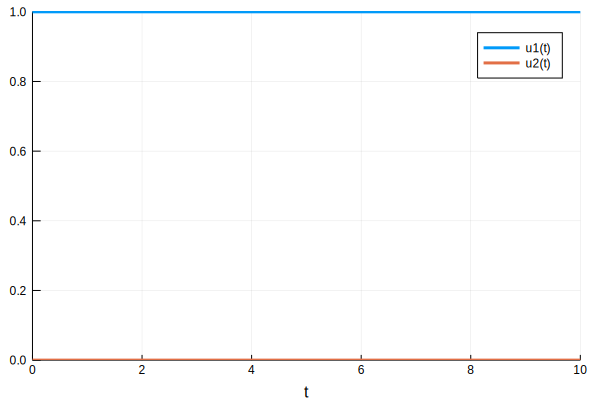

In [6]:
plot(sol)

In [7]:
# PD Control
Kp = 100.0
Kd = 100.0
τ1(u1,u2) = -Kp*u1 - Kd*u2;

p1 = [m, τ1];

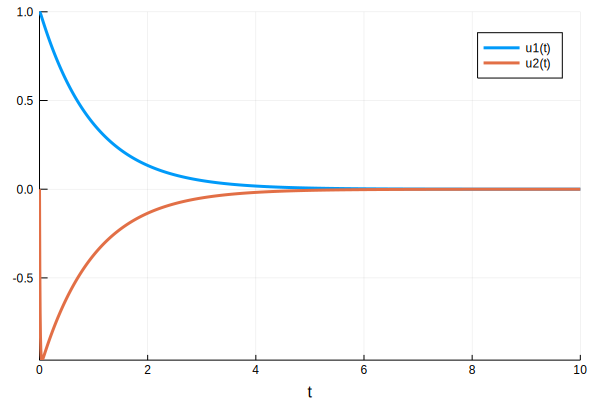

In [8]:
prob = ODEProblem(mass_no_friction, x0, tspan, p1);
sol  = solve(prob, reltol=1e-8, abstol=1e-8);
plot(sol)

In [9]:
# Adaptive Control Scheme (MRAC)

function adaptive_control_mass(desired)
    # Unpack desired trajectories
    x_d     = desired[1] # Desired position
    xdot_d  = desired[2] # Desired velocity
    xddot_d = desired[3] # Desired acceleration
    lambda  = desired[4] # Desired convergence rate
    γ       = desired[5] # Desired learning rate
    
    # Simplifications
    x_tilde(t, u1, u2)    = u1 - x_d(t)
    xdot_tilde(t, u1, u2) = u2 - xdot_d(t)
    v(t, u1, u2) = xddot_d(t) - 2*lambda*xdot_tilde(t, u1, u2) - lambda^2*x_tilde(t, u1, u2)
    s(t, u1, u2) = xdot_tilde(t, u1, u2) + lambda*x_tilde(t, u1, u2)
    
    # Controller design
    controller(u1,u2,u3,t) = u3*v(t, u1, u2)
    adapt_law(u1,u2,u3,t)  = -γ*v(t, u1, u2)*s(t, u1, u2)
    
    return controller, adapt_law
end

adaptive_control_mass (generic function with 1 method)

In [10]:
function mass_adaptive(du, u, p, t)
    
    # Unpack parameters 
    m          = p[1] # mass
    controller = p[2] # Controller
    adapt_law  = p[3] # Adaptation Law
    
    du[1] = u[2] # xdot             
    du[2] = controller(u[1], u[2], u[3], t)/m  # xddot 
    du[3] = adapt_law(u[1], u[2], u[3], t) # m_dot
end

mass_adaptive (generic function with 1 method)

In [11]:
using ForwardDiff

In [50]:
# Define the desired trajectories
x_d(t)     = sign.(sin.(2*t))
xdot_d(t)  = ForwardDiff.derivative(x_d, t)# 2*cos(2*t) 
xddot_d(t) = ForwardDiff.derivative(xdot_d, t)# -4*sin(2*t)

# Define rates
conv_rate    = 1. # Convergence rate
learn_rate   = 1. # Learning rate

# Generate controller and adaptation law
desired_params = [x_d, xdot_d, xddot_d, conv_rate, learn_rate] 
u_control, adapt = adaptive_control_mass(desired_params)


(controller, adapt_law)

In [51]:
# Setup control
x0 = [rand(), rand(), 0.]
println("Initial Condition: ", x0)

tspan = (0.0, 50.0)

# Parameters vector
# Define new mass
m = 1.0*rand()
println("Target Mass: ", m)

params = [m, u_control, adapt];

Initial Condition: [0.0334516, 0.481349, 0.0]
Target Mass: 0.921859787230781


In [52]:
prob = ODEProblem(mass_adaptive, x0, tspan, params);
sol  = solve(prob, reltol=1e-8, abstol=1e-8);


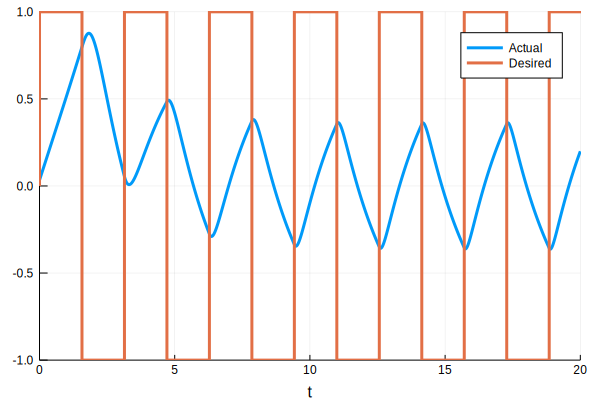

In [56]:
p1 = plot(sol,vars=(0,1), label="Actual", tspan=(0.,20))
plot!(sol.t, x_d(sol.t), linewidth=3.0, label="Desired")

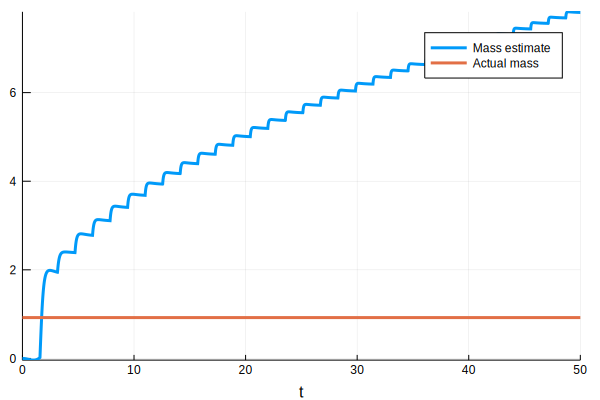

In [57]:
p2 = plot(sol, vars=(0,3), label="Mass estimate")
plot!(sol.t, m*ones(size(sol.t)), linewidth=3.0, label="Actual mass")


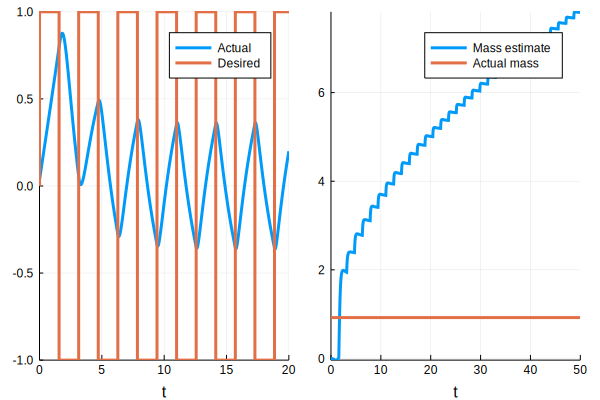

In [58]:
plot(p1,p2, layout=2)

In [17]:
println(sol[3,end])
size(sol.t)

4.365139341576765


(460,)

In [18]:
using Plots
gr()

Plots.GRBackend()

In [19]:
println(length(sol.t))

2282


In [21]:
# initial = x0[1:2]
# num_time_steps = length(sol.t)
num_time_steps = 200

scatter([sol[1,1]], [0],linewidth=7, xlim=(-1.0, 1.0), ylim=(-0.5, 0.5), legend=false, marker=(:square,5))
anim = @animate for i = 1:num_time_steps
    # Plot the current position
    scatter([sol[1,i]], [0],xlim=(-1.0, 1.0), ylim=(-0.5,0.5), linewidth=5,marker=(:square,5))
    
    
end
gif(anim, "double_integrator.gif", fps=30)

INFO: Saved animation to /home/luke/workspace/2.152_project/double_integrator.gif


Plots.AnimatedGif("/home/luke/workspace/2.152_project/double_integrator.gif")